[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OP_2025/blob/main/analysis_scripts/ATAC_METHYL_Analysis.ipynb)

# Clone github repo

In [ ]:
!git clone https://github.com/pachterlab/OP_2025.git
%cd /content/OP_2025/

# Download Data

In [ ]:
!mkdir omics_adata
!wget -P omics_adata https://data.caltech.edu/records/j57wp-0pp06/files/rat_ATAC_meta.h5ad?download=1
!mv omics_adata/rat_ATAC_meta.h5ad?download=1 omics_adata/rat_ATAC_meta.h5ad
!wget -P omics_adata https://data.caltech.edu/records/j57wp-0pp06/files/rat_RNA_meta.h5ad?download=1
!mv omics_adata/rat_RNA_meta.h5ad?download=1 omics_adata/rat_RNA_meta.h5ad
!wget -P omics_adata https://data.caltech.edu/records/j57wp-0pp06/files/rat_METHYL_meta.h5ad?download=1
!mv omics_adata/rat_METHYL_meta.h5ad?download=1 omics_adata/rat_METHYL_meta.h5ad

# Install Packages

In [ ]:
!pip install -qr requirements.txt

In [ ]:
import os, sys
sys.path.append('analysis_scripts')
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

import seaborn as sns
import matplotlib.pyplot as plt

import itertools

from rat_friend import *

In [3]:
color_dict = {'male': '#E07F80',
            'female': '#317EC2',
              'M': '#E07F80',
            'F': '#317EC2'
}

color_opts =  np.array([
    "#D55E00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#E69F00", "#CC79A7", "#666666", "#AD7700", "#1C91D4", "#007756", "#D5C711", "#005685",
    "#A04700", "#B14380", "#4D4D4D", "#FFBE2D", "#80C7EF", "#00F6B3", "#F4EB71", "#06A5FF", "#FF8320", "#D99BBD", "#8C8C8C", "#FFCB57", "#9AD2F2",
    "#2CFFC6", "#F6EF8E", "#38B7FF", "#FF9B4D", "#E0AFCA", "#A3A3A3", "#8A5F00", "#1674A9", "#005F45", "#AA9F0D", "#00446B", "#803800", "#8D3666",
    "#3D3D3D"
])
tissues = ['ADRNL','BAT','BLOOD','COLON','CORTEX','HEART','HIPPOC','HYPOTH',
 'KIDNEY','LIVER', 'LUNG','OVARY','SKM-GN','SKM-VL','SMLINT','SPLEEN','TESTES','VENACV','WAT']
for x in range(len(tissues)):
    color_dict[tissues[x]] = color_opts[x]

color_dict

{'male': '#E07F80',
 'female': '#317EC2',
 'M': '#E07F80',
 'F': '#317EC2',
 'ADRNL': '#D55E00',
 'BAT': '#56B4E9',
 'BLOOD': '#009E73',
 'COLON': '#F0E442',
 'CORTEX': '#0072B2',
 'HEART': '#E69F00',
 'HIPPOC': '#CC79A7',
 'HYPOTH': '#666666',
 'KIDNEY': '#AD7700',
 'LIVER': '#1C91D4',
 'LUNG': '#007756',
 'OVARY': '#D5C711',
 'SKM-GN': '#005685',
 'SKM-VL': '#A04700',
 'SMLINT': '#B14380',
 'SPLEEN': '#4D4D4D',
 'TESTES': '#FFBE2D',
 'VENACV': '#80C7EF',
 'WAT': '#00F6B3'}

# ATAC

In [4]:
omic = 'ATAC'
adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
sc.tl.pca(adata)

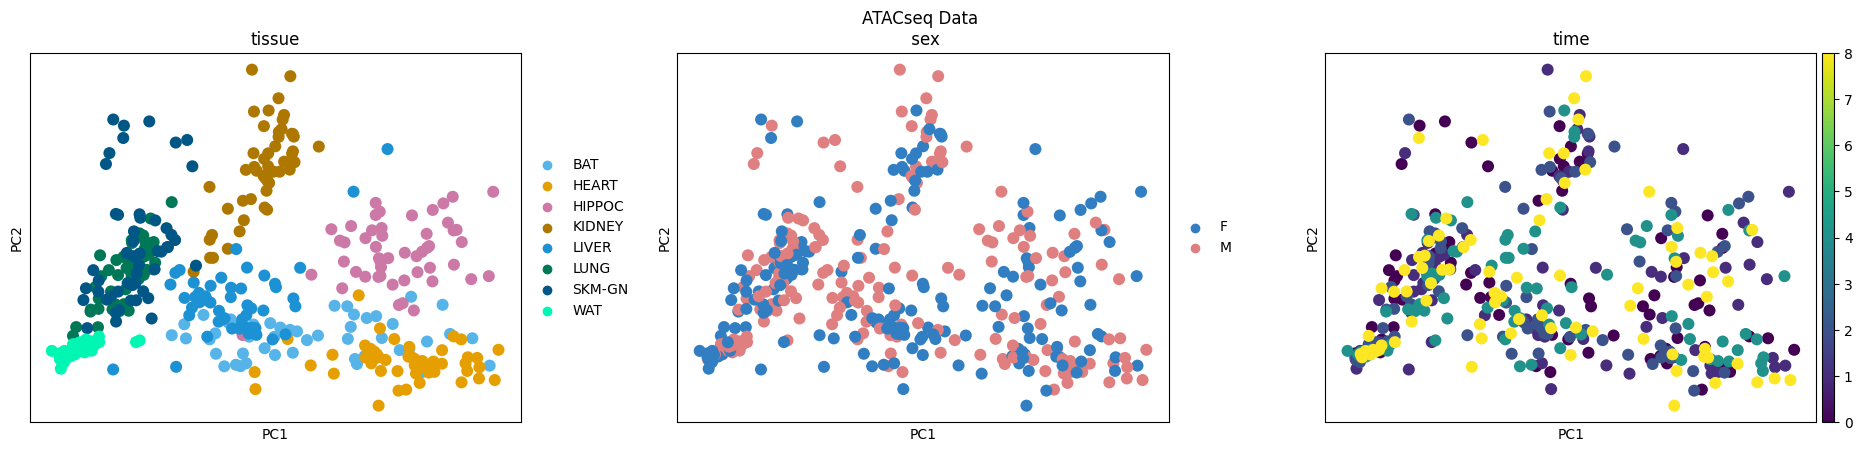

In [ ]:
sc.settings.figdir = 'figures_final'
sc.pl.pca(adata, title=['tissue', 'ATACseq Data \n sex', 'time'], color=['tissue', 'sex', 'time'], palette = color_dict, ncols=3,wspace=0.2,
         save = 'supp_fig_7a.png')

## Find if genes correlate with ATAC counts

In [6]:
atac_adata = adata[:,adata.var.custom_annotation == 'Promoter (<=1kb)']
atac_adata

View of AnnData object with n_obs × n_vars = 400 × 43635
    obs: 'X', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'group', 'sex', 'tissue', 'time', 'rank', 'nid', 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path'
    var: 'assay', 'assay_code', 'feature_ID', 'chrom', 'start', 'end', 'width', 'chipseeker_annotation', 'custom_annotation', 'distanceToTSS', 'relationship_to_gene', 'ensembl_gene', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'omic'
    uns: 'X_name', 'pca', 'tissue_colors', 'sex_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [7]:
rna_adata = load_annotated_omic('omics_adata/rat_RNA_meta.h5ad', 'RNA')
rna_adata

AnnData object with n_obs × n_vars = 861 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'X', 'omic'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

Filter for Tissues and Genes in both datasets

In [8]:
rna_adata = rna_adata[rna_adata.obs.tissue.isin(atac_adata.obs.tissue.unique())]
rna_adata

View of AnnData object with n_obs × n_vars = 392 × 24770
    obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
    var: 'X', 'omic'
    uns: 'X_name'
    layers: 'ambiguous', 'spliced', 'unspliced', 'counts'

In [9]:
# filter for shared rat+tissue combinations
filter_df = pd.merge(rna_adata.obs[['barcode', 'nid', 'tissue']], atac_adata.obs[['viallabel', 'nid', 'tissue']], on = ['nid', 'tissue'])
rna_adata = rna_adata[rna_adata.obs.barcode.isin(filter_df.barcode.values)]
atac_adata = atac_adata[atac_adata.obs.viallabel.isin(filter_df.viallabel.values)]

# filter for genes that are shared
atac_adata = atac_adata[:,atac_adata.var.ensembl_gene.isin(rna_adata.var.X.values)]
rna_adata = rna_adata[:,rna_adata.var.X.isin(atac_adata.var.ensembl_gene.unique())]
rna_adata, atac_adata

(View of AnnData object with n_obs × n_vars = 392 × 16299
     obs: 'barcode', 'path', 'nac_path', 'mat_path', 'amb_path', 'time', 'sex', 'tissue', 'viallabel', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variables.vo2_max_change', 'calculated.variables.coll_time_train', 'calculated.variables.deathtime_after_train', 'calculated.variables.frozetime_after_train', 'pid', 'group', 'rank', 'nid', 'num_umi', 'outlier', 'original_out', 'old_tissue'
     var: 'X', 'omic'
     uns: 'X_name'
     layers: 'ambiguous', 'spliced', 'unspliced', 'counts',
 View of AnnData object with n_obs × n_vars = 392 × 31743
     obs: 'X', 'viallabel', 'pid', 'calculated.variables.pct_body_fat_change', 'calculated.variables.pct_body_lean_change', 'calculated.variables.pct_body_fluid_change', 'calculated.variables.lactate_change_dueto_train', 'calculated.variable

Flatten Dataframes for comparison

In [10]:
atac_df = pd.DataFrame({'atac_counts':atac_adata.X.flatten(),
                        'atac_name':atac_adata.shape[0]*list(atac_adata.var.feature_ID.values),
                        'gene_name':atac_adata.shape[0]*list(atac_adata.var.ensembl_gene.values),
                        'nid':list(itertools.chain(*[atac_adata.shape[1]*[x] for x in atac_adata.obs.nid.values])),
                        'tissue':list(itertools.chain(*[atac_adata.shape[1]*[x] for x in atac_adata.obs.tissue.values]))
                       })
atac_df.head()

,atac_counts,atac_name,gene_name,nid,tissue
0,10,chr1:100234738-100234938,ENSRNOG00000021659,M0A,BAT
1,21,chr1:100296445-100296930,ENSRNOG00000019207,M0A,BAT
2,68,chr1:100297144-100298635,ENSRNOG00000019207,M0A,BAT
3,114,chr1:100359432-100360490,ENSRNOG00000037298,M0A,BAT
4,0,chr1:100378955-100379169,ENSRNOG00000019318,M0A,BAT


In [11]:
rna_df = pd.DataFrame({'rna_counts':rna_adata.X.flatten(),
             'gene_name':rna_adata.shape[0]*list(rna_adata.var.X.values),
                        'nid':list(itertools.chain(*[rna_adata.shape[1]*[x] for x in rna_adata.obs.nid.values])),
                        'tissue':list(itertools.chain(*[rna_adata.shape[1]*[x] for x in rna_adata.obs.tissue.values]))
                      })
rna_df.head()

,rna_counts,gene_name,nid,tissue
0,21.0,ENSRNOG00000000001,F1N,SKM-GN
1,5.0,ENSRNOG00000000007,F1N,SKM-GN
2,50.0,ENSRNOG00000000008,F1N,SKM-GN
3,0.0,ENSRNOG00000000009,F1N,SKM-GN
4,2.0,ENSRNOG00000000010,F1N,SKM-GN


In [12]:
big_count_df = pd.merge(atac_df,rna_df, on = ['gene_name', 'nid', 'tissue'])
#filter out genes with 0s for both
big_count_df = big_count_df[~((big_count_df.rna_counts == 0) &(big_count_df.atac_counts == 0))]
big_count_df.head(), big_count_df.shape

(   atac_counts                 atac_name           gene_name  nid tissue  \
 0           10  chr1:100234738-100234938  ENSRNOG00000021659  M0A    BAT   
 1           21  chr1:100296445-100296930  ENSRNOG00000019207  M0A    BAT   
 2           68  chr1:100297144-100298635  ENSRNOG00000019207  M0A    BAT   
 3          114  chr1:100359432-100360490  ENSRNOG00000037298  M0A    BAT   
 4            0  chr1:100378955-100379169  ENSRNOG00000019318  M0A    BAT   
 
    rna_counts  
 0         7.0  
 1         0.0  
 2         0.0  
 3         5.0  
 4        17.0  ,
 (12359642, 6))

In [13]:
r = scipy.stats.pearsonr(big_count_df.rna_counts.values, big_count_df.atac_counts.values)
r

PearsonRResult(statistic=0.10801756273016382, pvalue=0.0)

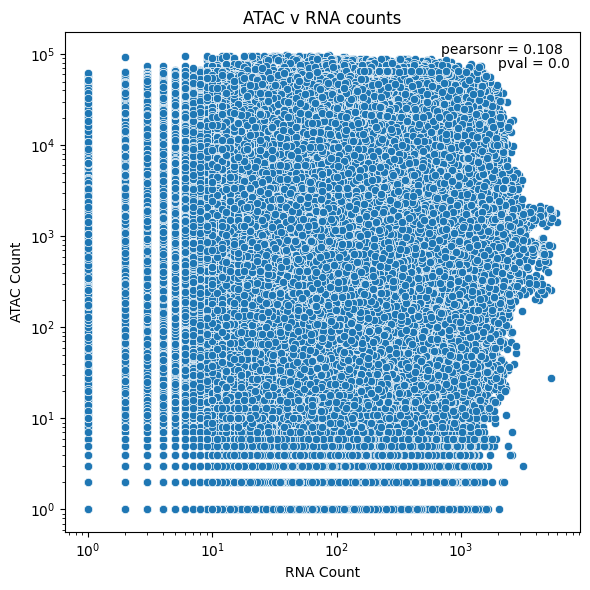

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(big_count_df, y = 'rna_counts', x='atac_counts')
plt.title('ATAC v RNA counts')
plt.text(7e2, 1e5, f'pearsonr = {round(r.statistic, 3)}', c = 'black')
plt.text(2e3, 7e4, f'pval = {round(r.pvalue, 3)}', c = 'black')
plt.xlabel('RNA Count')
plt.ylabel('ATAC Count')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig(f'figures_final/supp_fig_11.png')
plt.show()

# METHYL

In [15]:
omic = 'METHYL'
adata = load_annotated_omic(f'omics_adata/rat_{omic}_meta.h5ad', omic)
sc.tl.pca(adata)

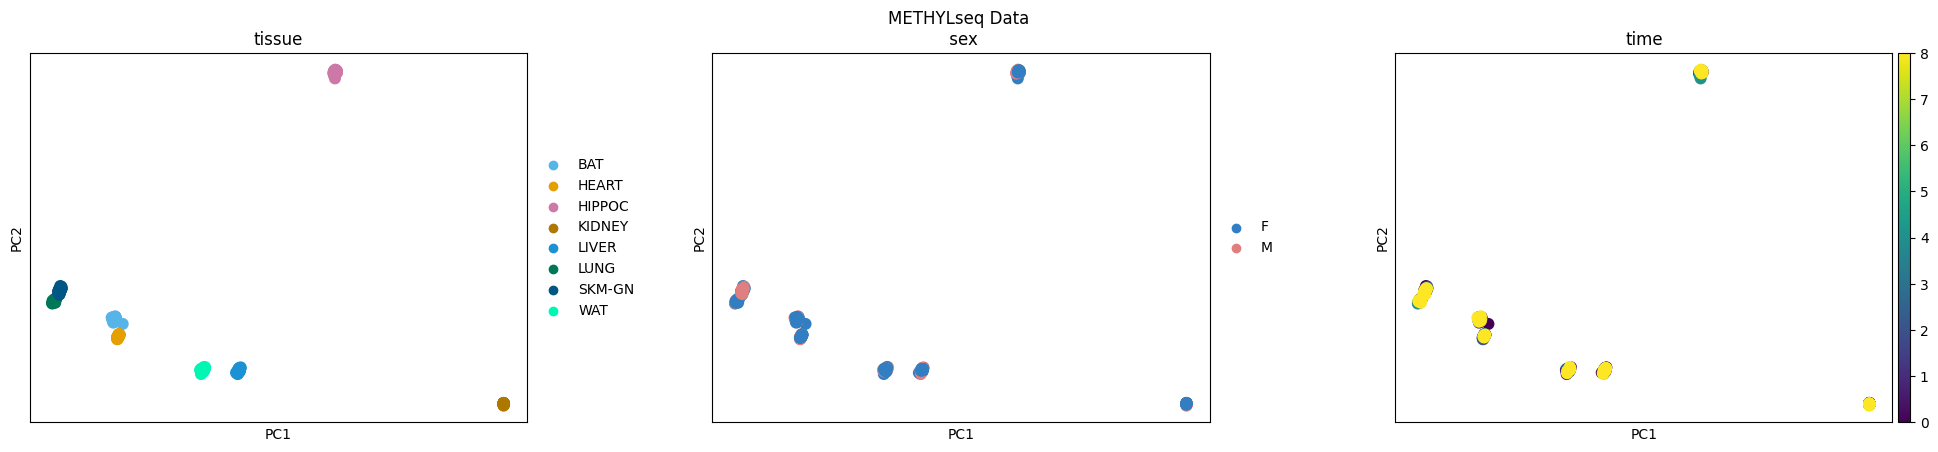

In [ ]:
sc.pl.pca(adata, title=['tissue', 'METHYLseq Data \n sex', 'time'], color=['tissue', 'sex', 'time'], palette = color_dict, ncols=3,wspace=0.25,
         save = 'supp_fig_7b.png')